# Init

In [1]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import glob
from scipy.spatial.distance import euclidean, pdist, squareform
import sys
sys.path.append(os.environ['CAPSTONE_PYTHON_SOURCE'])
#setting path to the env variable
folder = os.environ['CAPSTONE_DATA']
folder

'C:\\max\\Google Drive Max\\Max Shared\\Master Data Science\\2020-05 Capstone A\\msds_capstone\\data\\'

In [2]:
%load_ext autoreload
%autoreload 2


# Loading Dataset

In [3]:
from ETL.ETL import loadDataset, getTopProducts
from similarity.similarity import mergeTopSimilar, loadSimilarity
dataRaw= loadDataset(version=4)
dfSimilarity = loadSimilarity(version=4)
dfSimilarityAll = loadSimilarity(version=4,allCustomers=True)


In [4]:
#Parameters
ChainMaster = '' #'SPECS'
ProdCat='SUP PREM WHISKEY'
#Customer = 'TWIN PEAKS LIQUOR'

In [5]:
prods = getTopProducts(dataRaw,ChainMaster=ChainMaster,ProdCat=ProdCat,topN=3)
prods

['JACK DANIELS BLK WHSKY  1L',
 'JACK DANIELS BLK WHSKY 3PK W/2L COKE 1.75L',
 'JACK DANIELS BLK WHSKY  1.75L']

In [9]:

prod = prods[0]
colTime = 'WeekDate'
colPreds = ['9L Cases'] #Demand


(dataModel,colExog,colEnc,colDec) = mergeTopSimilar(dataRaw,dfSimilarityAll
                                                    ,ChainMaster=ChainMaster
                                                    ,Product=prod
                                                    ,ProductsList = prods
                                                    ,topn=5 
                                                    ,resampleFreq='M'
                                                    ,encodeCols=True)
                                                                        

print(colExog)
print(colDec)
print(dataModel.shape)
dataModel.head(5)

['0', '2', '1']
{'0': 'JACK DANIELS BLK WHSKY  1L', '1': 'JACK DANIELS BLK WHSKY 3PK W/2L COKE 1.75L', '2': 'JACK DANIELS BLK WHSKY  1.75L'}
(84, 6)


,WeekDate,Product,9L Cases,0,2,1
0,2013-01-31,JACK DANIELS BLK WHSKY 1L,262.01,428.571429,341.219206,341.219206
1,2013-02-28,JACK DANIELS BLK WHSKY 1L,224.77,638.120301,169.119658,341.219206
2,2013-03-31,JACK DANIELS BLK WHSKY 1L,190.19,638.120301,347.814408,178.396552
3,2013-04-30,JACK DANIELS BLK WHSKY 1L,281.96,622.118392,158.863248,342.948276
4,2013-05-31,JACK DANIELS BLK WHSKY 1L,200.83,633.944872,342.916064,342.916064


# SKTIME

In [169]:
import numpy as np
from sklearn.pipeline import Pipeline
from sktime.classification.compose import ColumnEnsembleClassifier
from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.classification.dictionary_based import BOSSEnsemble
from sktime.classification.shapelet_based import MrSEQLClassifier
from sktime.datasets import load_basic_motions
from sktime.transformers.series_as_features.compose import ColumnConcatenator
from sklearn.model_selection import train_test_split
from sktime.regression.compose import  TimeSeriesForestRegressor


In [170]:
trainSize = 4
xTrain = dataModel.iloc[:-trainSize][colExog]
xTest = dataModel.iloc[-trainSize:][colExog]
yTrain =  dataModel.iloc[:-trainSize]['9L Cases']
yTest =  dataModel.iloc[-trainSize:][colPreds].to_numpy
yTrain = pd.Series(yTrain)
#display(xTest,yTest,xTrain,yTrain)
yTrain

0       71.82
1       26.60
2       53.20
3       43.89
4       66.50
        ...  
356     74.48
357     78.47
358     74.48
359    111.72
360     37.24
Name: 9L Cases, Length: 361, dtype: float64

## Naive

In [220]:
from sktime.forecasting.naive import NaiveForecaster
#naive_forecaster = NaiveForecaster(strategy="last")
naive_forecaster = NaiveForecaster(strategy="seasonal_last",sp=4)
#naive_forecaster = NaiveForecaster(strategy="mean",window_length=10)
naive_forecaster.fit(yTrain)
y_last = naive_forecaster.predict([0,1,2])
y_last

360    74.48
361    78.47
362    74.48
dtype: float64

## Multivariate Regressor

not working as exogen regression not implemented yet

In [101]:
regressor = TimeSeriesForestRegressor()
regressor.fit(xTrain,yTrain)


ValueError: X must be univariate with X.shape[1] == 1, but found: X.shape[1] == 5. For multivariate problems please consider compositor classes. Estimator-specific multivariate approaches are not implemented yet.

# Prophet

In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
%matplotlib inline

In [11]:
dataModel

,WeekDate,Product,9L Cases,0,2,1
0,2013-01-31,JACK DANIELS BLK WHSKY 1L,262.01,428.571429,341.219206,341.219206
1,2013-02-28,JACK DANIELS BLK WHSKY 1L,224.77,638.120301,169.119658,341.219206
2,2013-03-31,JACK DANIELS BLK WHSKY 1L,190.19,638.120301,347.814408,178.396552
3,2013-04-30,JACK DANIELS BLK WHSKY 1L,281.96,622.118392,158.863248,342.948276
4,2013-05-31,JACK DANIELS BLK WHSKY 1L,200.83,633.944872,342.916064,342.916064
...,...,...,...,...,...,...
79,2019-08-31,JACK DANIELS BLK WHSKY 1L,363.09,460.511278,371.179487,197.327586
80,2019-09-30,JACK DANIELS BLK WHSKY 1L,305.90,694.556391,188.674264,187.735110
81,2019-10-31,JACK DANIELS BLK WHSKY 1L,316.54,694.556391,365.396923,375.103448
82,2019-11-30,JACK DANIELS BLK WHSKY 1L,301.91,698.436090,370.153846,375.103448


In [12]:
trainSize = 4
data2 = dataModel.copy()
data2['date'] = pd.to_datetime(dataModel['WeekDate'])
data2=data2.rename(columns={'9L Cases':'y','date':'ds'})

cols=['ds','y'] + colExog
train = data2.iloc[:-trainSize][ cols ]

test = data2.iloc[-trainSize:][ cols ]
display(train,test)



,ds,y,0,2,1
0,2013-01-31,262.01,428.571429,341.219206,341.219206
1,2013-02-28,224.77,638.120301,169.119658,341.219206
2,2013-03-31,190.19,638.120301,347.814408,178.396552
3,2013-04-30,281.96,622.118392,158.863248,342.948276
4,2013-05-31,200.83,633.944872,342.916064,342.916064
...,...,...,...,...,...
75,2019-04-30,316.54,693.485834,366.051282,374.172414
76,2019-05-31,325.85,460.511278,185.589744,197.327586
77,2019-06-30,299.25,469.562252,381.035409,193.189655
78,2019-07-31,304.57,460.511278,377.128205,377.128205


,ds,y,0,2,1
80,2019-09-30,305.90,694.556391,188.674264,187.735110
81,2019-10-31,316.54,694.556391,365.396923,375.103448
82,2019-11-30,301.91,698.436090,370.153846,375.103448
83,2019-12-31,589.19,699.327475,566.820513,370.153846


In [79]:
m = Prophet(yearly_seasonality=False
            ,weekly_seasonality=False
            ,daily_seasonality=False
            #,seasonality_mode='multiplicative'
            ,seasonality_prior_scale=25
            ,changepoint_range=0.95
           )
m.add_regressor('0')
m.add_regressor('1')
m.add_regressor('2')
m.fit(train)

## Prediction

In [17]:

forecast = m.predict(test)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
display(test)


,ds,yhat,yhat_lower,yhat_upper
0,2019-09-30,367.211315,241.608548,487.052216
1,2019-10-31,365.458452,234.187414,490.955916
2,2019-11-30,367.883472,240.651514,491.589035
3,2019-12-31,385.299967,247.866622,506.927706


,ds,y,0,2,1
80,2019-09-30,305.90,694.556391,188.674264,187.735110
81,2019-10-31,316.54,694.556391,365.396923,375.103448
82,2019-11-30,301.91,698.436090,370.153846,375.103448
83,2019-12-31,589.19,699.327475,566.820513,370.153846


In [32]:
#checking if the prediction changes by changing the predictors
test2=test.copy()
test2['2']=100
forecast = m.predict(test2)
display(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
        ,test)

,ds,yhat,yhat_lower,yhat_upper
0,2019-09-30,360.253802,230.902616,488.822059
1,2019-10-31,344.635020,223.593529,476.868701
2,2019-11-30,346.686805,221.160201,482.768548
3,2019-12-31,348.672545,211.039356,476.533535


,ds,y,0,2,1
80,2019-09-30,305.90,694.556391,188.674264,187.735110
81,2019-10-31,316.54,694.556391,365.396923,375.103448
82,2019-11-30,301.91,698.436090,370.153846,375.103448
83,2019-12-31,589.19,699.327475,566.820513,370.153846


## Rolling Window

In [153]:
from datetime import datetime
print(train.shape)
print(train.ds.min())
print(train.ds.max())
total_days= abs((train.ds.min() - train.ds.max()).days)
folds=3
horizon_obs = 8
horizon_days = (train['ds'].max() - train.iloc[-horizon_obs]['ds']).days 
initial_days = total_days - folds * horizon_days
periods_days = horizon_days

initial=str(initial_days-5)+ " D"
period = str(periods_days)+ " D"
horizon=str(horizon_days+5)+ " D"

print(f'total days {total_days}')
print(f'initial days {initial}')
print(f'period days {period}')
print(f'horizon days {horizon}')

(80, 5)
2013-01-31 00:00:00
2019-08-31 00:00:00
total days 2403
initial days 1762 D
period days 212 D
horizon days 217 D


In [154]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial=initial, period=period, horizon = horizon) #M for months
# 
# Last Test from Max Date - Horizon  TO Max Date  
df_cv

INFO:fbprophet:Making 3 forecasts with cutoffs between 2017-11-28 00:00:00 and 2019-01-26 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2017-11-30,335.285712,201.581763,479.206860,472.04,2017-11-28
1,2017-12-31,329.218257,201.018482,460.209366,422.94,2017-11-28
2,2018-01-31,330.175877,213.520707,452.379068,86.45,2017-11-28
3,2018-02-28,333.084347,199.210743,461.983955,256.58,2017-11-28
4,2018-03-31,335.424371,210.226155,470.523582,428.26,2017-11-28
5,2018-04-30,336.414325,197.769734,474.610801,320.53,2017-11-28
6,2018-05-31,329.362180,197.340627,454.166508,353.78,2017-11-28
7,2018-06-30,342.797421,208.486496,474.591408,254.03,2017-11-28
8,2018-06-30,341.649085,208.487081,478.432872,254.03,2018-06-28
9,2018-07-31,335.060786,197.085388,482.654487,259.35,2018-06-28


In [155]:
df_cv[df_cv['cutoff']=='2014-06-05']
df_cv.groupby('cutoff')['ds'].count()

cutoff
2017-11-28    8
2018-06-28    8
2019-01-26    8
Name: ds, dtype: int64

In [149]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,12865.889409,113.427904,113.427904,0.533026,0.533026,1.0
1,31 days,2138.225723,46.240953,36.811527,0.137211,0.137211,1.0
2,62 days,2657.738274,51.553257,51.255169,0.149939,0.149939,1.0
3,92 days,1359.874005,36.876470,30.210727,0.095811,0.095811,1.0
4,123 days,8494.528815,92.165768,66.206374,0.355681,0.355681,0.5


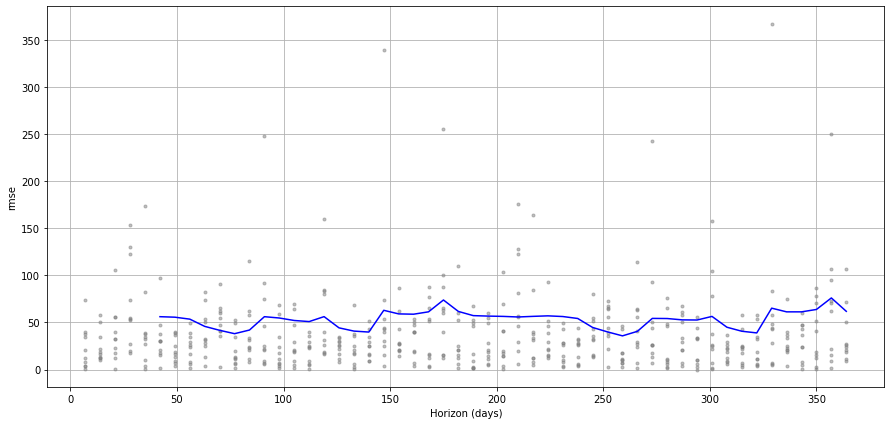

In [251]:
from fbprophet.plot import plot_cross_validation_metric
fig,ax = plt.subplots(figsize=(15,7))
fig=plot_cross_validation_metric(df_cv, metric='rmse',ax=ax,rolling_window=0.1)
